## <center> Ridge and LightGBM: simple blending 

In this competition, the metric is mean absolute error (MAE), so it's better to optimize it directly. We'll do it with LightGBM, a powerfull implementation of gradient boosting. Remember: with Ridge regression we optimize mean squared error (MSE), and it's not the same as optimizing MAE. However, do to sparse features, Ridge will still work better than boosting in this problem, however mixing predictions of two models will further help to decrease MAE. 
So we'll apply a very simple method of averaging model predictions: blending. 

<img src='https://habrastorage.org/webt/gm/ns/jp/gmnsjpxmgabagmi-bgialqtuhqa.png' width=30%>

Finally, here we'll apply a simple hack, one from the family of leaderboard probing techniques.

# Extracting titles from raw data

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
import lightgbm as lgb # No 32bit version :(

The following code will help to throw away all HTML tags from article content/title.

In [3]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Path to competition data, change this if you'd like to.

In [4]:
PATH_TO_DATA = '../../data/medium/'

Assume you have all data downloaded from competition's [page](https://www.kaggle.com/c/how-good-is-your-medium-article/data) in the PATH_TO_DATA folder and `.gz` files are ungzipped.

Supplementary function to read a JSON line without crashing on escape characters. 

In [5]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

This function takes a JSON and forms a txt file leaving only article titles. When you resort to feature engineering and extract various features from articles, a good idea is to modify this function.

In [6]:
path_in = os.path.join(PATH_TO_DATA, 'train.json')
with open(path_in, encoding='utf-8') as inp_file:
    post = []
    for i in range(0, 10):
        json_line = inp_file.readline()
        post.append(read_json_line(json_line))

page = post[3]

date = page['published']['$date']
pd.to_datetime(date)

Timestamp('2017-05-06 08:16:30.776000')

def extract_titles_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            title = json_data['title'].replace('\n', ' ').replace('\r', ' ')
            title_no_html_tags = strip_tags(title)
            out_file.write(title_no_html_tags + '\n')

In [8]:
def extract_titles_from_json(path_to_inp_json_file, path_to_out_txt_file, total_length):
    '''
    :param path_to_inp_json_file: path to a JSON file with train/test data
    :param path_to_out_txt_file: path to extracted features (here titles), one per line
    :param total_length: we'll pass the hardcoded file length to make tqdm even more convenient
    '''
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file, \
         open(path_to_out_txt_file, 'w', encoding='utf-8') as out_file:
        new_json = []
        for line in tqdm_notebook(inp_file, total=total_length):
            json_data = read_json_line(line)
            title = json_data['title'].replace('\n', ' ')\
                                        .replace('\r', ' ')

            title_no_html = strip_tags(title)
            content = json_data['content'].replace('\n', ' ')\
                                            .replace('\r', ' ')\
                                            .replace('</div>', ' </div>')
            content_no_html = strip_tags(content)                                    # add content to title
            content_no_html_trunc = content_no_html[:300] + content_no_html[-300:]
            pub_date = json_data['published']['$date']
            new_json_line = {'content': title_no_html + content_no_html_trunc, 'date':date}
            out_file.write(json.dumps(new_json_line))
            out_file.write('\n')

In [9]:
%%time
extract_titles_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'train.json'),
           path_to_out_txt_file='train_titles.txt', total_length=62313)


CPU times: user 3min 56s, sys: 3 s, total: 3min 59s
Wall time: 4min


In [10]:
%%time
extract_titles_from_json(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 'test.json'),
           path_to_out_txt_file='test_titles.txt', total_length=34645)


CPU times: user 2min 15s, sys: 2.06 s, total: 2min 17s
Wall time: 2min 17s


# Feature engineering (simple Tf-Idf for titles)
We'll use a very simple feature extractor – `TfidfVectorizer`, meaning that we resort to the Bag-of-Words approach. For now, we are leaving only 50k features. 

In [11]:
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1, 3))

In [12]:
%%time
df_train = pd.read_json('train_titles.txt', lines=True)
df_test = pd.read_json('test_titles.txt', lines=True)

CPU times: user 625 ms, sys: 168 ms, total: 793 ms
Wall time: 826 ms


In [13]:
%%time
X_train = tfidf.fit_transform(df_train.content)

CPU times: user 34.6 s, sys: 1.09 s, total: 35.7 s
Wall time: 35.3 s


In [14]:
%%time
X_test = tfidf.transform(df_test.content)

CPU times: user 7.77 s, sys: 39.5 ms, total: 7.81 s
Wall time: 7.85 s


In [15]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

Read targets from file.

In [16]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                        'train_log1p_recommends.csv'), 
                           index_col='id')

In [17]:
y_train = train_target['log_recommends'].values

Target is still somewhat skewed, though it's allready `log1p`-transformed (#claps with `log1p` transformation). Yet, we'll apply `log1p` once more time.

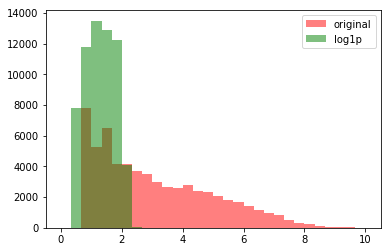

In [18]:
plt.hist(y_train, bins=30, alpha=.5, color='red', 
         label='original', range=(0,10));
plt.hist(np.log1p(y_train), bins=30, alpha=.5, color='green', 
         label='log1p', range=(0,10));
plt.legend();

In [19]:
def add_time_features(X_sparse, df):
    
    hour = df.date.apply(lambda ts: ts.hour).astype(np.int8)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
   
    weekend = df.date.apply(lambda ts: ts.dayofweek > 5).astype(np.int8).values.reshape(-1,1)

    day_of_week = df.date.apply(lambda t: t.weekday()).values.reshape(-1, 1)
    day_of_week_sc = StandardScaler().fit_transform(day_of_week)
    
    month = df.date.apply(lambda t: t.month).values.reshape(-1,1)
    month_sc = StandardScaler().fit_transform(month)
    
    yyyymm = df.date.apply(lambda ts: ts.year * 100 + ts.month).astype(np.float).values.reshape(-1, 1)
    yyyymm_sc = StandardScaler().fit_transform(yyyymm)
    
    
    X = csr_matrix( hstack([X_sparse, morning, day, evening, night,yyyymm_sc, 
                day_of_week_sc, weekend, month_sc]) )
    
    feat_name = ['morning', 'day', 'evening', 'night', 'yyyymm_sc', 
                'day_of_week_sc', 'weekend', 'month_sc']
    
    return X, feat_name

In [20]:
X_feat_train, feat_names = add_time_features(X_train, df_train)
X_feat_test, _ = add_time_features(X_test, df_test)

/home/andrey/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/andrey/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/andrey/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/andrey/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/andrey/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: D

In [21]:
X_feat_train.shape, X_feat_test.shape

((62313, 50008), (34645, 50008))

In [22]:
X_feat_train

<62313x50008 sparse matrix of type '<class 'numpy.float64'>'
	with 7287814 stored elements in Compressed Sparse Row format>

In [23]:
X_train

<62313x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 7225501 stored elements in Compressed Sparse Row format>

# Validation and model training
Let's make a 30%-holdout set. 

In [24]:
train_part_size = int(0.7 * train_target.shape[0])

In [25]:
train_part_size

43619

In [26]:
X_train_part = X_feat_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_feat_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

Now we are ready to fit a linear model.

In [27]:
ridge = Ridge(random_state=17)

In [28]:
%%time
ridge.fit(X_train_part, np.log1p(y_train_part));

CPU times: user 2.98 s, sys: 31.8 ms, total: 3.01 s
Wall time: 2.89 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

After `log1p`-transformation, we need to apply an inverse  `expm1`-trasformation to predictions.

In [29]:
ridge_pred = np.expm1(ridge.predict(X_valid))

Then, we fit a LightGBM model with `mean_absolute_error` as objective (it's important!).

In [30]:
lgb_x_train_part = lgb.Dataset(X_train_part.astype(np.float32), 
                           label=np.log1p(y_train_part))

In [31]:
lgb_x_valid = lgb.Dataset(X_valid.astype(np.float32), 
                      label=np.log1p(y_valid))

In [32]:
param = {'num_leaves': 255, 
         'objective': 'mean_absolute_error',
         'metric': 'mae'}

In [33]:
num_round = 200
bst_lgb = lgb.train(param, lgb_x_train_part, num_round, 
                    valid_sets=[lgb_x_valid], early_stopping_rounds=20)

[1]	valid_0's l1: 0.378991
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.371431
[3]	valid_0's l1: 0.365073
[4]	valid_0's l1: 0.359269
[5]	valid_0's l1: 0.354444
[6]	valid_0's l1: 0.350282
[7]	valid_0's l1: 0.346786
[8]	valid_0's l1: 0.343554
[9]	valid_0's l1: 0.340892
[10]	valid_0's l1: 0.338097
[11]	valid_0's l1: 0.335779
[12]	valid_0's l1: 0.333585
[13]	valid_0's l1: 0.332074
[14]	valid_0's l1: 0.330406
[15]	valid_0's l1: 0.329288
[16]	valid_0's l1: 0.328277
[17]	valid_0's l1: 0.327079
[18]	valid_0's l1: 0.326087
[19]	valid_0's l1: 0.32501
[20]	valid_0's l1: 0.324093
[21]	valid_0's l1: 0.323381
[22]	valid_0's l1: 0.322782
[23]	valid_0's l1: 0.322291
[24]	valid_0's l1: 0.321785
[25]	valid_0's l1: 0.321361
[26]	valid_0's l1: 0.321002
[27]	valid_0's l1: 0.320526
[28]	valid_0's l1: 0.320168
[29]	valid_0's l1: 0.31965
[30]	valid_0's l1: 0.319
[31]	valid_0's l1: 0.318627
[32]	valid_0's l1: 0.318361
[33]	valid_0's l1: 0.317968
[34]	valid_0's l1: 0.317478


In [34]:
lgb_pred = np.expm1(bst_lgb.predict(X_valid.astype(np.float32), 
                                    num_iteration=bst_lgb.best_iteration))

Let's plot predictions and targets for the holdout set. Recall that these are #recommendations (= #claps) of Medium articles with the `np.log1p` transformation.

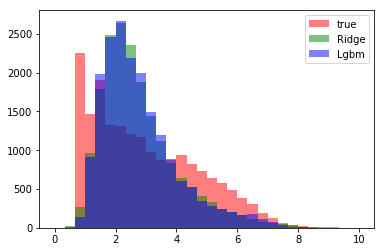

In [35]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(lgb_pred, bins=30, alpha=.5, color='blue', label='Lgbm', range=(0,10));
plt.legend();

As we can see, the prediction is far from perfect, and we get MAE $\approx$ 1.3 that corresponds to $\approx$ 2.7 error in #recommendations.

In [36]:
ridge_valid_mae = mean_absolute_error(y_valid, ridge_pred)
ridge_valid_mae

1.1094473167677623

In [37]:
lgb_valid_mae = mean_absolute_error(y_valid, lgb_pred)
lgb_valid_mae

1.1400104042715926

# Simple blending
Now let's mix predictions. We's just pick up weights 0.6 for Lgbm and 0.4 for Ridge, but these are typically tuned via cross-validation. 

In [38]:
mean_absolute_error(y_valid, .4 * lgb_pred + .6 * ridge_pred)

1.093333546510044

Finally, train both models on the full accessible training set, make predictions for the test set and form submission files. 

In [39]:
%%time
ridge.fit(X_train, np.log1p(y_train));

CPU times: user 3.29 s, sys: 76 µs, total: 3.29 s
Wall time: 3.18 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [40]:
%%time
ridge_test_pred = np.expm1(ridge.predict(X_test))

CPU times: user 15.5 ms, sys: 24 µs, total: 15.5 ms
Wall time: 17.3 ms


In [41]:
lgb_x_train = lgb.Dataset(X_train.astype(np.float32),
                          label=np.log1p(y_train))

In [42]:
num_round = 60
bst_lgb = lgb.train(param, lgb_x_train, num_round)

In [43]:
lgb_test_pred = np.expm1(bst_lgb.predict(X_test.astype(np.float32)))

Here's a simple mix

In [44]:
mix_pred = .4 * lgb_test_pred + .6 * ridge_test_pred

# Leaderboard probing

Now we apply a dirty hack. Originally, we made you come up with it by your own (as a part of an assignment, with only a hint from out side), but now it's described in [this](https://nbviewer.jupyter.org/github/Yorko/mlcourse.ai/blob/master/jupyter_english/tutorials/kaggle_leaderboard_probing_nikolai_timonin.ipynb) tutorial, written within a previous session of [mlcourse.ai](https://mlcourse.ai).

Submitting all zeros gives 4.33328. If you take a pen and a piece of paper and figure out what it means for MAE that all predictions are zeros, then you'll see that it's exactly the mean target value for the test set. We can compare it with mean target for training data and correspondingly adjust predictions. Looks like a dirty hack, however, the same thing is often done with time series prediction (even in production) - merely adjusting your predictions to a change in target variable distribution.

In [45]:
mean_test_target = 4.33328 

In [46]:
mix_test_pred_modif = mix_pred + mean_test_target - y_train.mean()

In [47]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [48]:
#write_submission_file(ridge_test_pred + mean_test_target - y_train.mean(), 'ridge_submission.csv')

In [49]:
#write_submission_file(lgb_test_pred + mean_test_target - y_train.mean(), 'lgb_submission.csv')

In [50]:
write_submission_file(mix_test_pred_modif, 'submission.csv')

Public MAEs:

- Ridge – 1.65253
- LGBM – 1.69407
- Ridge-LGBM mix – 1.64080

As we can see, simple blending decreases MAE for both holdout predictions and on the leaderboard. However, I don't recommend to play with blending/stacking schemes un the beginning of the competition  – it's crucially important to come up with good features first.

You can further improve your model in various ways. I've described them in [this kernel](https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline). Go and compete, good luck!